# `rioxarray`

`rioxarray`:

- is a python extension for `xarray` to manipuate `xarray.DataArray's` as rasters
- means *raster input/output + xarray*

## Data 

Raster files from the US National Agriculture Imagery Program (NAIP)
- high resolution images from 2020 with four spectral bands : Red, Green, Blue, and Near-infrared (NIR)
- data is pre-processed into two rasters (RBG and NIR)


## Import .tif

In [3]:
import os # to worth with file paths
import numpy as np
import matplotlib.pyplot as plt 

import rioxarray as rioxr

import geopandas as gpd
from shapely.geometry import Polygon

There are multiple ways of opening a .tif file using `xarray` or `rioxarray`.

Use `rioxarray.open_rasterio()` function to open the `tif` file

In [7]:
# make file path
nir_fp = os.path.join(os.getcwd(),'data','nir.tif')

nir = rioxr.open_rasterio(nir_fp)
# get current working directory
#os.getcwd()

nir

<xarray.DataArray (band: 1, y: 3208, x: 2419)>
[7760152 values with dtype=uint8]
Coordinates:
  * band         (band) int64 1
  * x            (x) float64 2.512e+05 2.512e+05 ... 2.527e+05 2.527e+05
  * y            (y) float64 3.813e+06 3.813e+06 ... 3.811e+06 3.811e+06
    spatial_ref  int64 0
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0

## `xr.DataArray` exploration

Let's verify we loaded an `xarray.DataArray`

In [8]:
type(nir)

xarray.core.dataarray.DataArray

In [9]:
# access some attributes
print('shape', nir.shape)
print('data type:', nir.dtype)

shape (1, 3208, 2419)
data type: uint8


In [11]:
# check values of array at the corners
print(type(nir.values))
nir.values

<class 'numpy.ndarray'>


array([[[167, 164, 161, ..., 147, 152, 151],
        [170, 170, 168, ..., 151, 149, 154],
        [176, 177, 177, ..., 151, 151, 151],
        ...,
        [ 94,  88, 101, ...,  83,  88,  79],
        [108,  95, 103, ...,  92,  91,  75],
        [ 94,  90, 104, ...,  87,  88,  82]]], dtype=uint8)

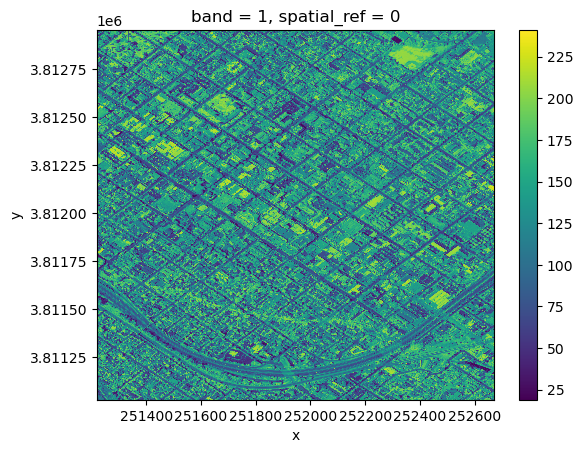

In [12]:
# exploratory plot
nir.plot()

## `rio` accessor

An *accessor* in Python lets us access a different set of properties from an object.
Use the `.rio` accessor for `xarray.DataArray` to access its raster properties.

Example

In [14]:
print('# bands:' ,nir.rio.count)
print('height:', nir.rio.height)
print('width:', nir.rio.width)
print('resolution :', nir.rio.resolution())
print('no data values:', nir.rio.nodata, '\n')

print('spatial bounding box:')
print(nir.rio.bounds(), '\n')
print('CRS:', nir.rio.crs)

# bands: 1
height: 3208
width: 2419
resolution : (0.6000000000000072, -0.600000000000058)
no data values: None 

spatial bounding box:
(251218.8, 3811027.2, 252670.19999999998, 3812952.0) 

CRS: EPSG:26911


In [15]:
nir.rio.crs.is_projected

True

# Multiband raster

In [19]:
# open RGB raster
rgb_fp = os.path.join(os.getcwd(),'data','rgb.tif')
rgb = rioxr.open_rasterio(rgb_fp)
rgb

<xarray.DataArray (band: 3, y: 3208, x: 2419)>
[23280456 values with dtype=uint8]
Coordinates:
  * band         (band) int64 1 2 3
  * x            (x) float64 2.512e+05 2.512e+05 ... 2.527e+05 2.527e+05
  * y            (y) float64 3.813e+06 3.813e+06 ... 3.811e+06 3.811e+06
    spatial_ref  int64 0
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0

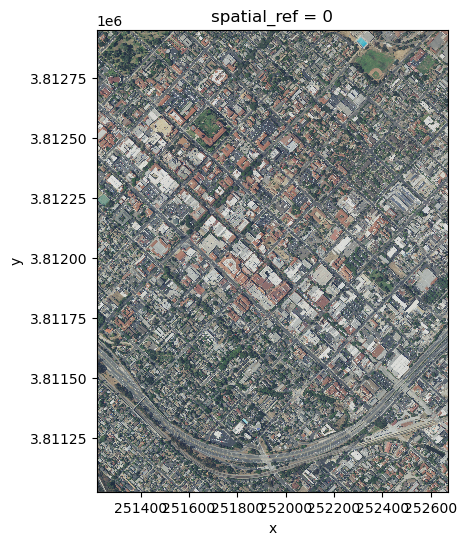

In [20]:
# parameters for plotting this raster
size = 6 # size of figure
aspect = rgb.rio.width / rgb.rio.height # ratio width/height

#plot three bands as RGB image 
rgb.plot.imshow(size = size, aspect = aspect)

## Box for clipping

Our area of interest (aoi) is a smaller region 

In [23]:
# list vertices of our aoi box 
points = [[-119.70608227128903, 34.426300194372274],
          [-119.70608227128903, 34.42041139020533],
          [-119.6967885126002, 34.42041139020533],
          [-119.6967885126002, 34.426300194372274],
          [-119.70608227128903, 34.426300194372274]]

#make a geodataframe with aoi
aoi = gpd.GeoDataFrame(geometry = [Polygon(points)],
                       crs = 'epsg:4326')
aoi

,geometry
0,"POLYGON ((-119.70608 34.42630, -119.70608 34.4..."


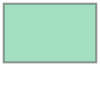

In [22]:
Polygon(points)

<AxesSubplot:>

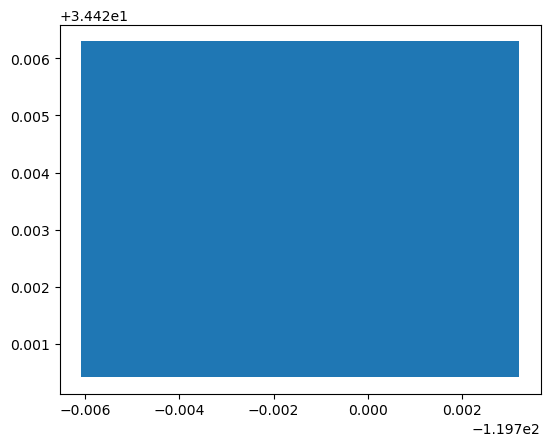

In [24]:
aoi.plot()

## Clip raster

Remember: **if two geospatial sets will interact, they need to be in the same CRS**
Check:

In [26]:
print('aoi:', aoi.crs)
print('nir:', nir.rio.crs)
print('rgb:',rgb.rio.crs)

aoi: epsg:4326
nir: EPSG:26911
rgb: EPSG:26911


In [29]:
#reproject aoi to rgb crs
aoi = aoi.to_crs(rgb.rio.crs)
print('matched crs? :' ,aoi.crs == rgb.rio.crs)

aoi.crs

matched crs? : True


<Bound CRS: PROJCS["NAD83 / UTM zone 11N",GEOGCS["NAD83",DATUM ...>
Name: NAD83 / UTM zone 11N
Axis Info [cartesian]:
- [east]: Easting (metre)
- [north]: Northing (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: Transformation from NAD83 to WGS84
- method: Position Vector transformation (geog2D domain)
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich
Source CRS: NAD83 / UTM zone 11N

<AxesSubplot:title={'center':'spatial_ref = 0'}, xlabel='x', ylabel='y'>

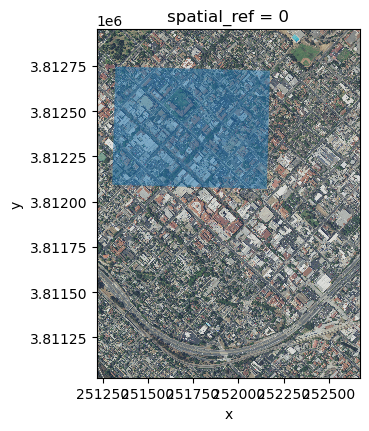

In [33]:
# plot aoi outline and RBG raster together
fig, ax = plt.subplots()
fig.set_size_inches((size, size*aspect)) #cannot use ax and size, aspect together
rgb.plot.imshow(ax = ax)
aoi.plot(ax = ax, alpha = 0.5)

To clip the raster using the aoi polygon, we use the `.rio.clip_box()` method

In [34]:
# clip rasters to aoi
rgb_small = rgb.rio.clip_box(*aoi.total_bounds)
nir_small = nir.rio.clip_box(*aoi.total_bounds)

In [35]:
print('original shape:', rgb.shape)
print('reduced shape:', rgb_small.shape)

original shape: (3, 3208, 2419)
reduced shape: (3, 1128, 1454)


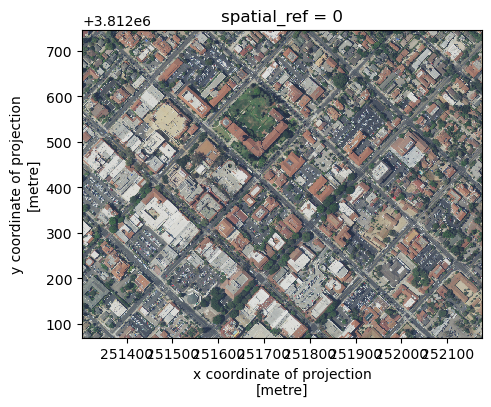

In [37]:
# plot it with correct ratio
size = 4 # height in inches
aspect = rgb_small.rio.width / rgb_small.rio.height

rgb_small.plot.imshow(size = size, aspect = aspect)